# Temperature Timeseries RNN (LSTM)

In [ ]:
# download data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-05-26 11:38:09--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.225.40
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.225.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  56.2MB/s    in 0.2s    

2022-05-26 11:38:09 (56.2 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
# Listing 10.1 Inspecting the data of the Jena weather dataset
import os
fname = os.path.join("jena_climate_2009_2016.csv")
 
with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
# Listing 10.2 Parsing the data
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  # We store column 1 in the “temperature” array.
  temperature[i] = values[1]
  # We store all columns (including the temperature) in the “raw_data” array
  raw_data[i, :] = values[:] 

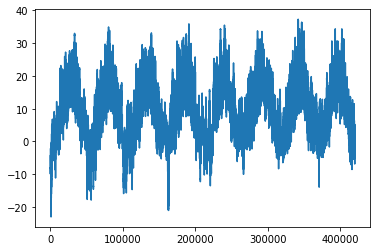

In [ ]:
# Listing 10.3 Plotting the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

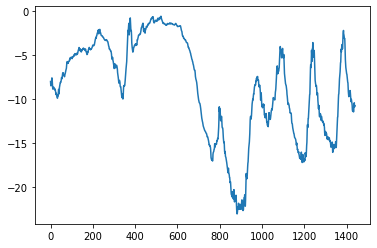

In [ ]:
# Listing 10.4 Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temperature[:1440])

In [ ]:
# Listing 10.5 Computing the number of samples we’ll use for each data split
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
# check data
import pandas as pd
raw_data_pd = pd.DataFrame(raw_data,columns=header[1:])
raw_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   "p (mbar)"         420451 non-null  float64
 1   "T (degC)"         420451 non-null  float64
 2   "Tpot (K)"         420451 non-null  float64
 3   "Tdew (degC)"      420451 non-null  float64
 4   "rh (%)"           420451 non-null  float64
 5   "VPmax (mbar)"     420451 non-null  float64
 6   "VPact (mbar)"     420451 non-null  float64
 7   "VPdef (mbar)"     420451 non-null  float64
 8   "sh (g/kg)"        420451 non-null  float64
 9   "H2OC (mmol/mol)"  420451 non-null  float64
 10  "rho (g/m**3)"     420451 non-null  float64
 11  "wv (m/s)"         420451 non-null  float64
 12  "max. wv (m/s)"    420451 non-null  float64
 13  "wd (deg)"         420451 non-null  float64
dtypes: float64(14)
memory usage: 44.9 MB


In [ ]:
raw_data_pd.describe()

,"""p (mbar)""","""T (degC)""","""Tpot (K)""","""Tdew (degC)""","""rh (%)""","""VPmax (mbar)""","""VPact (mbar)""","""VPdef (mbar)""","""sh (g/kg)""","""H2OC (mmol/mol)""","""rho (g/m**3)""","""wv (m/s)""","""max. wv (m/s)""","""wd (deg)"""
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


In [ ]:
# Listing 10.6 Normalizing the data
# only on train data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np 
from tensorflow import keras

In [ ]:
# Listing 10.7 Instantiating datasets for training, validation, and testing

# sampling_rate = 6
  # Observations will be sampled at one data point per hour
  # we will only keep one data point out of 6
sampling_rate = 6
# sequence_length = 120
  # Observations will go back 5 days (120 hours).
sequence_length = 120
# delay = sampling_rate * (sequence_length + 24 - 1)
  # The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
 
train_dataset = keras.utils.timeseries_dataset_from_array(
    # skip last entries from raw data
    raw_data[:-delay],
    # skip inital interies from raw data
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
 
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
 
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
# Listing 10.8 Inspecting the output of one of our datasets
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
# Listing 10.9 Computing the common-sense baseline MAE
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
 
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.39
Test MAE: 2.77


In [ ]:
# Listing 10.10 Training and evaluating a densely connected model
from tensorflow import keras 
from tensorflow.keras import layers
 
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)
 
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") 

Epoch 1/10
819/819 [==============================] - 64s 77ms/step - loss: 13.0911 - mae: 2.7838 - val_loss: 11.4789 - val_mae: 2.6791
Epoch 2/10
819/819 [==============================] - 65s 80ms/step - loss: 9.1854 - mae: 2.3833 - val_loss: 9.8738 - val_mae: 2.4806
Epoch 3/10
819/819 [==============================] - 62s 75ms/step - loss: 8.4127 - mae: 2.2840 - val_loss: 10.1153 - val_mae: 2.5043
Epoch 4/10
819/819 [==============================] - 62s 75ms/step - loss: 7.9577 - mae: 2.2232 - val_loss: 10.0054 - val_mae: 2.4930
Epoch 5/10
819/819 [==============================] - 64s 78ms/step - loss: 7.6015 - mae: 2.1767 - val_loss: 11.2146 - val_mae: 2.6676
Epoch 6/10
819/819 [==============================] - 64s 78ms/step - loss: 7.3228 - mae: 2.1392 - val_loss: 12.9430 - val_mae: 2.8720
Epoch 7/10
819/819 [==============================] - 64s 78ms/step - loss: 7.1291 - mae: 2.1125 - val_loss: 11.1505 - val_mae: 2.6577
Epoch 8/10
819/819 [==============================] - 6

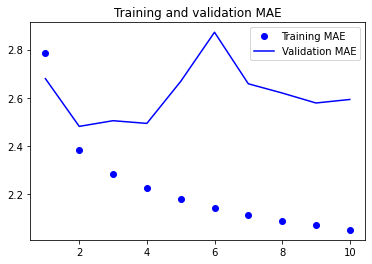

In [ ]:
# Listing 10.11 Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

- It is not good than the simple baseline method

In [ ]:
# Temperature problem with 1D convents

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
             keras.callbacks.ModelCheckpoint("jena_conv.keras",save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)
 
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 100s 121ms/step - loss: 22.7003 - mae: 3.7092 - val_loss: 15.3657 - val_mae: 3.0913
Epoch 2/10
819/819 [==============================] - 100s 121ms/step - loss: 15.2714 - mae: 3.0870 - val_loss: 14.7151 - val_mae: 3.0497
Epoch 3/10
819/819 [==============================] - 101s 123ms/step - loss: 14.1115 - mae: 2.9647 - val_loss: 15.8357 - val_mae: 3.1570
Epoch 4/10
819/819 [==============================] - 110s 134ms/step - loss: 13.2043 - mae: 2.8704 - val_loss: 16.1043 - val_mae: 3.1852
Epoch 5/10
819/819 [==============================] - 106s 129ms/step - loss: 12.4053 - mae: 2.7848 - val_loss: 15.9923 - val_mae: 3.1553
Epoch 6/10
819/819 [==============================] - 105s 127ms/step - loss: 11.8741 - mae: 2.7253 - val_loss: 15.1538 - val_mae: 3.0656
Epoch 7/10
819/819 [==============================] - 112s 136ms/step - loss: 11.4072 - mae: 2.6745 - val_loss: 15.0280 - val_mae: 3.0573
Epoch 8/10
819/819 [==============

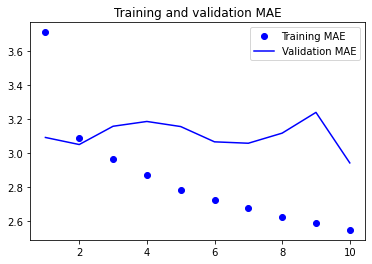

In [ ]:
# Listing 10.11 Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

- even worse results


In [ ]:
# long short term memory
# Listing 10.12 A simple LSTM-based model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
 
callbacks = [
             keras.callbacks.ModelCheckpoint("jena_lstm.keras",save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 125s 149ms/step - loss: 46.4668 - mae: 4.9417 - val_loss: 13.0507 - val_mae: 2.7360
Epoch 2/10
819/819 [==============================] - 120s 146ms/step - loss: 10.9823 - mae: 2.5648 - val_loss: 9.5309 - val_mae: 2.3986
Epoch 3/10
819/819 [==============================] - 120s 147ms/step - loss: 9.6552 - mae: 2.4160 - val_loss: 9.3241 - val_mae: 2.3629
Epoch 4/10
819/819 [==============================] - 120s 147ms/step - loss: 9.1650 - mae: 2.3525 - val_loss: 9.5549 - val_mae: 2.3939
Epoch 5/10
819/819 [==============================] - 120s 146ms/step - loss: 8.8289 - mae: 2.3062 - val_loss: 9.5379 - val_mae: 2.4026
Epoch 6/10
819/819 [==============================] - 119s 145ms/step - loss: 8.6090 - mae: 2.2768 - val_loss: 9.6574 - val_mae: 2.4107
Epoch 7/10
819/819 [==============================] - 117s 143ms/step - loss: 8.3927 - mae: 2.2493 - val_loss: 9.6542 - val_mae: 2.4156
Epoch 8/10
819/819 [=========================

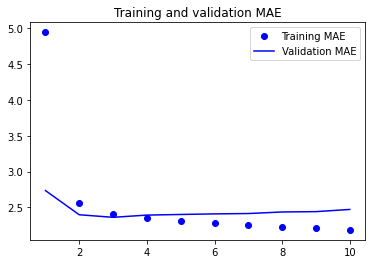

In [ ]:
# Listing 10.11 Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

- LSTM based model performed somewhat batter

---